<a href="https://colab.research.google.com/github/Shaileshps21/pytorch-/blob/main/Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diffusion (DDPM:Denoising diffusion probabilistic model)**

The work and algorithm is based on the paper: Jonathan Ho et al. “Denoising diffusion probabilistic models.”

Diffusion Model can be divided into two parts:

Forward Diffusion Process - add noise to the image.

Reverse Diffusion Process - remove noise from the image.


**Forward Diffusion Process :**

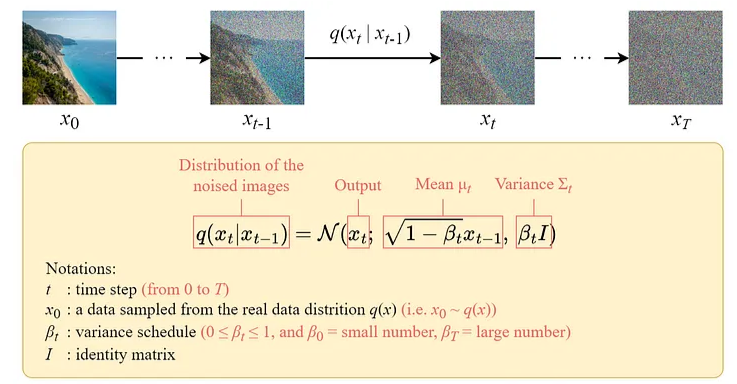

Lets Move into some details of forward diffusion process:

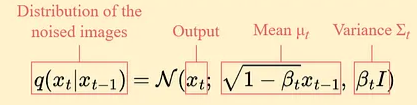

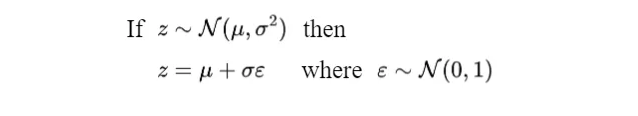

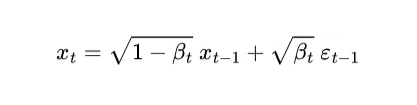

Instead of finding $x_t$ from $x_{t-1}$, We can find $x_t$ from $x_0$ as follow:

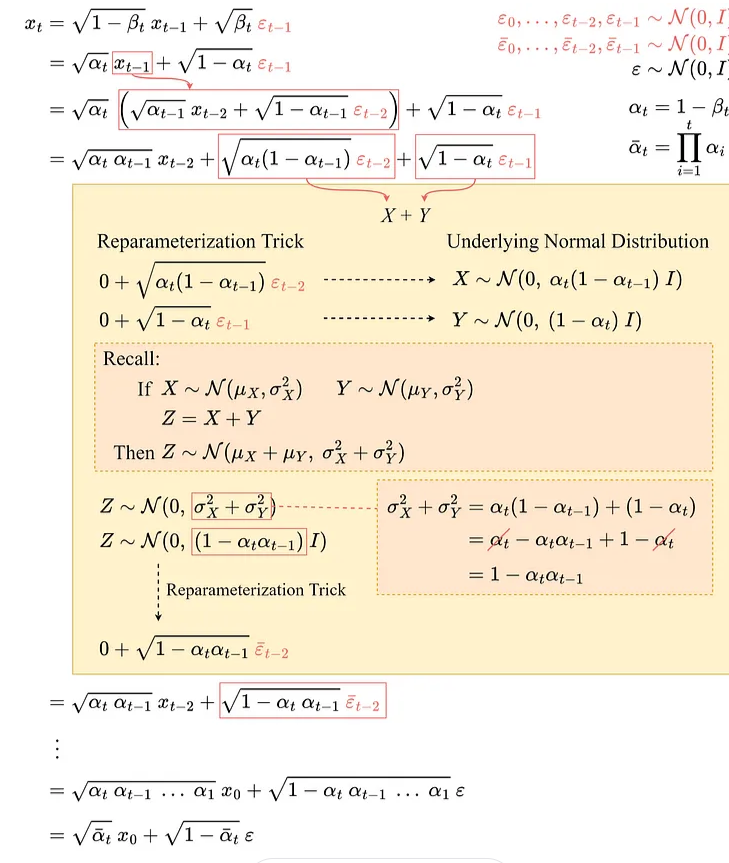

$q(x_t|x_0) = \cal{N}(x_{t},\sqrt{\bar{\alpha_t}}x_0,(1-\bar{\alpha_t}))$

**Reverse Diffusion Process:**

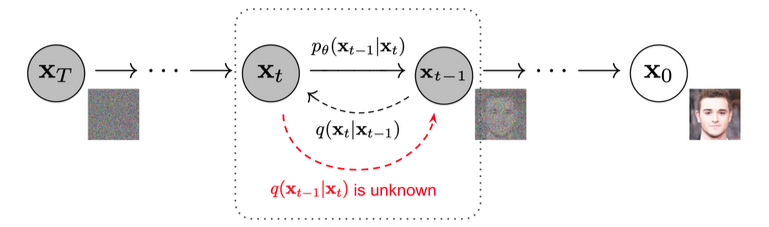

**Reverse Diffusion Process:**

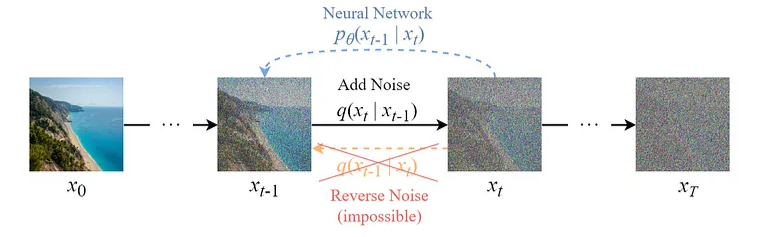


Here, we need a loss function from which our model can learn.

KL divergence between the posterior and the distribution learned by the nueral network.

$\cal{D}_{KL}(q(x_{t-1}|x_t,x_0)||(p_θ(x_{t-1}|x_t))$

To compute $q(x_{t-1}|x_t,x_0$, use the Bayes' Theorem:


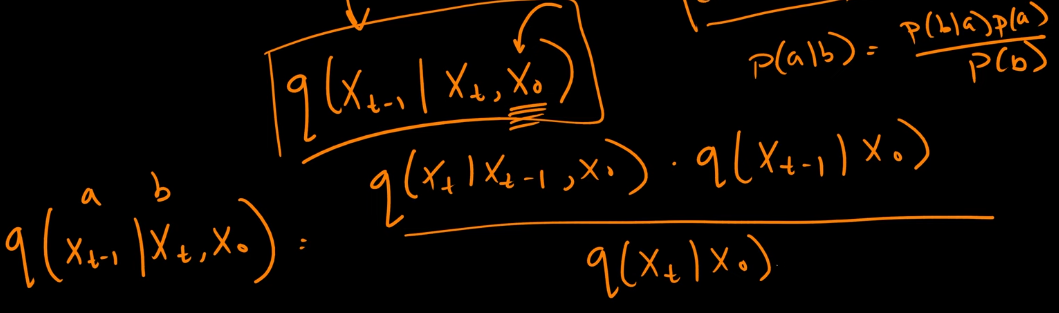



We already know:

$q(x_t|x_0) = \cal{N}(x_{t},\sqrt{\bar{\alpha_t}}x_0,(1-\bar{\alpha_t}))$

$q(x_{t-1}|x_0) = \cal{N}(x_{t-1},\sqrt{\bar{\alpha}_{t-1}}x_0,(1-\bar{\alpha}_{t-1}))$

$q(x_t|x_{t-1}) = \cal{N}(x_{t},\sqrt{1-\beta_t}x_{t-1},\beta_t)$

Use the Gaussian formula to compute: Keep focus on the the term $x_{t-1}$. Simplify the expression by ignoring the constant terms. For more details the youtube link shared in references.

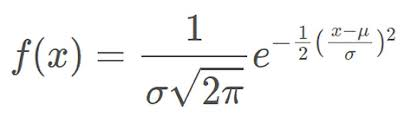

You will get the mean and vairance of the posterior.

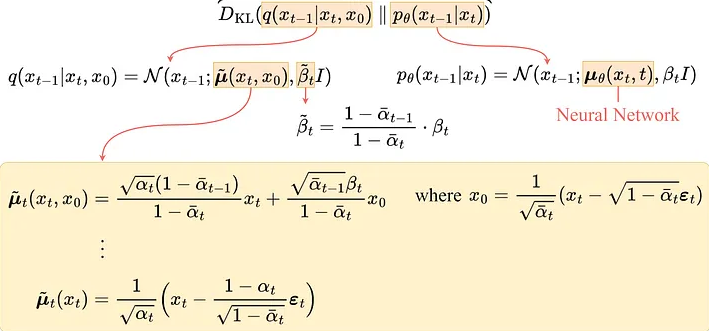

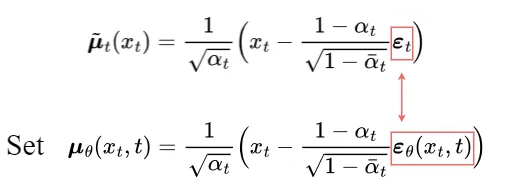

Loss function for training the model :

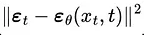

So for training: for the sample $x_0$, find $x_t = \sqrt{\bar{\alpha_t}}x_0+\sqrt{(1-\bar{\alpha_t})}ϵ_{t}$

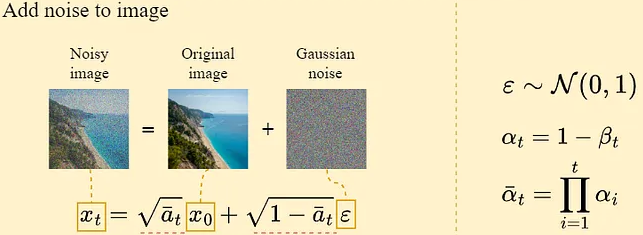

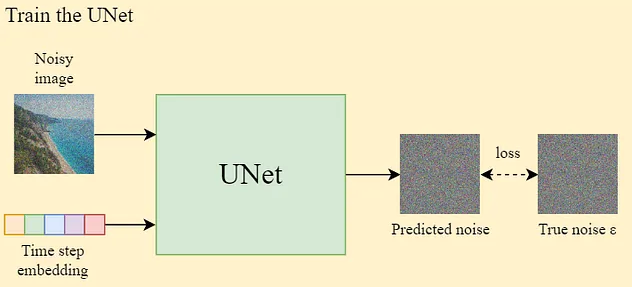

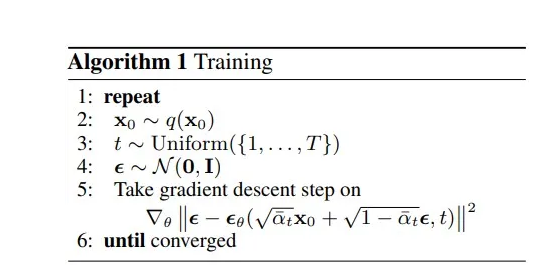

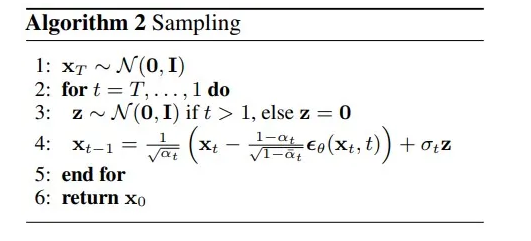

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [13]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


Time embedding using sinusoidal positional encoding used in Transformer - "Attention is all you need"

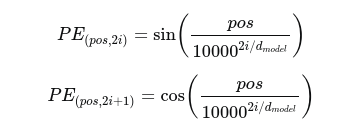

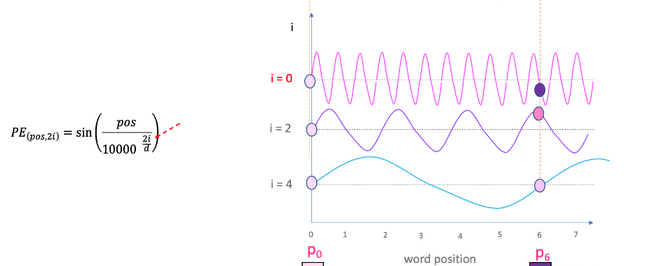

In [14]:
class TimeEmbedding(nn.Module):
    """"""
    def __init__(self, embed_dim):
        super().__init__()
        self.embed_dim = embed_dim

    def forward(self, t):
        # t is shape (batch_size,)
        half_dim = self.embed_dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=t.device) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
        return embeddings

for time embedding, lets compute  $\frac{t}{10000^{\frac{2i}{d}}}$

$\frac{t}{e^{\{\frac{2i}{d}*\ln(10000)\}}} = t \times e^{-\{i \times \frac{1}{d/2} \times \ln(10000)\} }$

In [15]:
class UNet(nn.Module):

    def __init__(self, time_embed_dim=32):
        super().__init__()
        self.time_embed_dim = time_embed_dim
        self.time_embed = TimeEmbedding(time_embed_dim)

        # Encoder (downsampling)
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)

        # Time embedding projection layers for encoder
        self.time_proj1 = nn.Linear(time_embed_dim, 64)
        self.time_proj2 = nn.Linear(time_embed_dim, 128)
        self.time_proj3 = nn.Linear(time_embed_dim, 256)

        # Time embedding projection layers for decoder
        self.time_proj4 = nn.Linear(time_embed_dim, 128)
        self.time_proj5 = nn.Linear(time_embed_dim, 64)
        self.time_proj6 = nn.Linear(time_embed_dim, 1)

        # Decoder (upsampling)
        self.conv4 = nn.Conv2d(256, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv6 = nn.Conv2d(64, 1, 3, padding=1)

        self.pool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, x, t):
        # Get time embeddings
        t_emb = self.time_embed(t)  # (batch_size, time_embed_dim)

        # Encoder
        h1 = F.relu(self.conv1(x))  # (B, 64, 28, 28)
        h1 = h1 + self.time_proj1(t_emb)[:, :, None, None]  # Add time embedding

        h2 = F.relu(self.conv2(self.pool(h1)))  # (B, 128, 14, 14)
        h2 = h2 + self.time_proj2(t_emb)[:, :, None, None]  # Add time embedding

        h3 = F.relu(self.conv3(self.pool(h2)))  # (B, 256, 7, 7)
        h3 = h3 + self.time_proj3(t_emb)[:, :, None, None]  # Add time embedding

        # Decoder
        h4 = F.relu(self.conv4(self.upsample(h3)))  # (B, 128, 14, 14)
        h4 = h4 + h2  # Skip connection
        h4 = h4 + self.time_proj4(t_emb)[:, :, None, None]  # Add time embedding

        h5 = F.relu(self.conv5(self.upsample(h4)))  # (B, 64, 28, 28)
        h5 = h5 + h1  # Skip connection
        h5 = h5 + self.time_proj5(t_emb)[:, :, None, None]  # Add time embedding

        output = self.conv6(h5)  # (B, 1, 28, 28)
        output = output + self.time_proj6(t_emb)[:, :, None, None]  # Add time embedding

        return output

In [16]:
batch_size = 16
beta_start, beta_end, timesteps = 1e-4, 0.02, 1000
betas = torch.linspace(beta_start, beta_end, timesteps)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)



$x_t = \sqrt{\bar{\alpha_t}}x_0+\sqrt{(1-\bar{\alpha_t})}ϵ_{t}$


In [17]:
def forward_diffusion(x_0, t, noise=None):

    if noise is None:
        noise = torch.randn_like(x_0)

    # Get the right values for batch of timesteps
    sqrt_alphas_cumprod_t = torch.sqrt(alphas_cumprod[t])[:, None, None, None].to(device)
    sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1 - alphas_cumprod[t])[:, None, None, None].to(device)

    x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise

    return x_t, noise

In [18]:
# Prepare MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [19]:
model = UNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

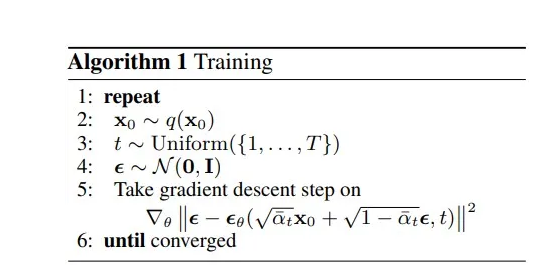

In [26]:
model.train()
epoch_loss = 0.0
num_epochs = 10


for epoch in range(num_epochs):
        epoch_loss = 0.0

        for _, (x_0, _) in enumerate(tqdm(dataloader,  desc=f"Epoch {epoch+1}/{num_epochs}")):
            x_0 = x_0.to(device)

            # Sample random timesteps
            t = torch.randint(0, timesteps, (x_0.shape[0],)).to(device)

            x_t, actual_noise = forward_diffusion(x_0, t)

            optimizer.zero_grad()
            # Forward pass
            predicted_noise = model(x_t, t)

            # Compute loss (MSE between predicted and actual noise)
            loss = F.mse_loss(predicted_noise, actual_noise)

            # Backward pass

            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)

        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.6f}")

Epoch 1/10: 100%|██████████| 3750/3750 [00:38<00:00, 97.66it/s] 


Epoch 1/10, Average Loss: 0.094166


Epoch 2/10: 100%|██████████| 3750/3750 [00:37<00:00, 99.13it/s] 


Epoch 2/10, Average Loss: 0.093785


Epoch 3/10: 100%|██████████| 3750/3750 [00:37<00:00, 101.06it/s]


Epoch 3/10, Average Loss: 0.095856


Epoch 4/10: 100%|██████████| 3750/3750 [00:37<00:00, 101.23it/s]


Epoch 4/10, Average Loss: 0.093310


Epoch 5/10: 100%|██████████| 3750/3750 [00:37<00:00, 100.75it/s]


Epoch 5/10, Average Loss: 0.094907


Epoch 6/10: 100%|██████████| 3750/3750 [00:37<00:00, 101.11it/s]


Epoch 6/10, Average Loss: 0.093602


Epoch 7/10: 100%|██████████| 3750/3750 [00:40<00:00, 92.94it/s]


Epoch 7/10, Average Loss: 0.094905


Epoch 8/10: 100%|██████████| 3750/3750 [00:37<00:00, 99.73it/s]


Epoch 8/10, Average Loss: 0.093270


Epoch 9/10: 100%|██████████| 3750/3750 [00:37<00:00, 101.08it/s]


Epoch 9/10, Average Loss: 0.095541


Epoch 10/10: 100%|██████████| 3750/3750 [00:37<00:00, 100.62it/s]

Epoch 10/10, Average Loss: 0.093552


In [27]:
torch.save(model.state_dict(),'last.pth')

In [28]:
model = UNet().to(device)
model.load_state_dict(torch.load('last.pth', map_location = device))
# model.load_state_dict(torch.load('last_200.pth', map_location = device))

<All keys matched successfully>

In [29]:
import cv2
def display_image(tensor,timestep):

    tensor = tensor * 0.5 + 0.5  # [0,1] range

    # Make grid
    grid_img = torchvision.utils.make_grid(tensor)

    # Convert to NumPy for plotting
    np_grid = grid_img.permute(1, 2, 0).cpu().numpy()

    # Plot
    plt.figure(figsize=(5, 5))
    plt.imshow(np.clip(np_grid, 0, 1))
    plt.title(f"Sampled Images at timestep {timestep}")
    plt.axis('off')
    plt.show()

In [30]:
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)
alphas_cumprod_prev = torch.cat([torch.tensor([1.0], device=device), alphas_cumprod[:-1]])
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

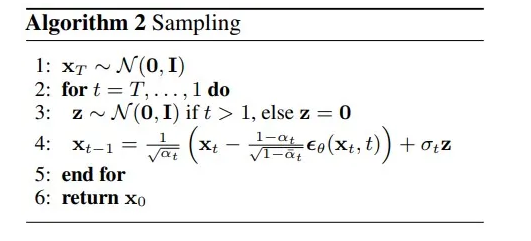

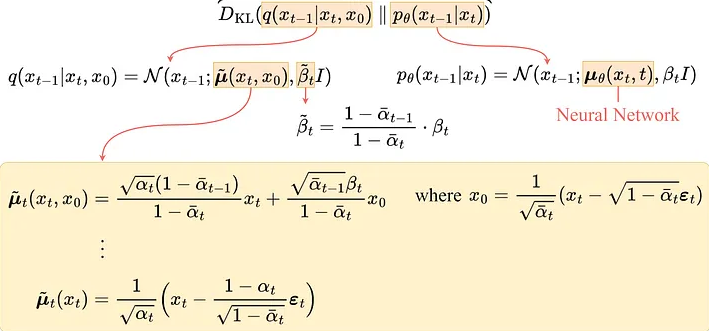

192it [00:00, 625.71it/s]

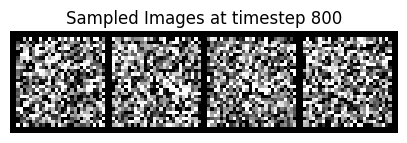

381it [00:00, 565.18it/s]

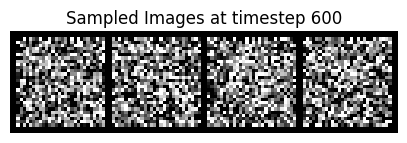

580it [00:00, 616.68it/s]

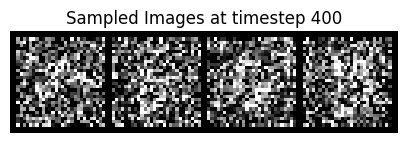

768it [00:01, 578.91it/s]

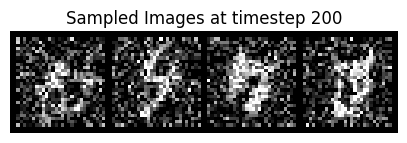

950it [00:01, 557.92it/s]

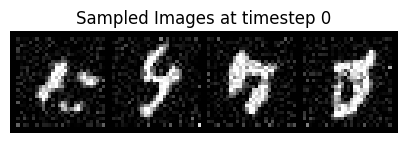

1000it [00:01, 562.53it/s]


In [31]:
num_samples = 4
img_size = 28

model.eval()
x = torch.randn(num_samples,1,img_size,img_size).to(device)

for t in tqdm(reversed(range(timesteps))):

    t_repeated = torch.full((num_samples,),t, dtype = torch.long).to(device)

    with torch.no_grad():
        predicted_noise = model(x,t_repeated)

    if t > 0:
        noise = torch.randn_like(x)
        sigma = torch.sqrt((1 - alphas_cumprod_prev[t]) / (1 - alphas_cumprod[t]) * betas[t])
        x = sqrt_recip_alphas[t] * (x - betas[t] / sqrt_one_minus_alphas_cumprod[t] * predicted_noise) + sigma * noise
    else:
        x = sqrt_recip_alphas[t] * (x - betas[t] / sqrt_one_minus_alphas_cumprod[t] * predicted_noise)

    if t%200==0:  # Save every 200 steps
        display_image(x, t)

**Reference:**

1.  https://arxiv.org/pdf/2006.11239 (DDPM paper)
2. https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf (Attention is all you need)
3. https://roysubhradip.hashnode.dev/a-beginners-guide-to-diffusion-models-understanding-the-basics-and-beyond
4. https://www.youtube.com/watch?v=dSC9XOPJXK8 (
Mathing the Diffusion Model: Where do all those Equations Come From?? )